In [142]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import geopy.distance
from skimage.util.shape import view_as_windows

In [140]:
def visualisation(a,b,c):
    
    figpolar = plt.figure()
    
#     h = []
#     l = []
#     for i, ax in enumerate(a):
#         h.append(np.arctan2(b[i], ax))
#         l.append(np.sqrt(ax**2 + b[i]**2))
    
#     ax = figpolar.add_subplot(111, projection='polar')
#     ax.scatter(h, l)
    
    ax2 = figpolar.add_subplot(222)
    ax2.scatter(a,b)


def visualise(data):
    xs = [0]
    ys = [0]
    for i, row in enumerate(data): 
        x, y = row
        xs.append(x*0.1+xs[i])
        ys.append(y*0.1+ys[i])
    print(xs[len(xs)-1])
    print(ys[len(ys)-1])
    visualisation(xs, ys, [0]*len(xs))


In [122]:
#Load data
path = 'IMU/OxIOD/handheld'
train = [[1,7],[2,3],[3,5],[4,5]]
test = [[5,4]]

def read(locations):
    imu = []
    vicon = []
    for i in locations:
        j,k = i[0],i[1]
        l = 1
        while l <= k:
            ids = pd.read_csv(path+'/data'+str(j)+'/syn/imu'+str(l)+'.csv', header=None)
            vds = pd.read_csv(path+'/data'+str(j)+'/syn/vi'+str(l)+'.csv', header=None)
            imu.append(ids)
            vicon.append(vds)
            l = l + 1
    imu = pd.concat(imu)
    vicon = pd.concat(vicon)
    
    imu.drop(imu.columns[[0,1,2,3,7,8,9,13,14,15]],axis=1,inplace=True)
    extra = (len(imu)%10)
    imu = imu[:-extra]
    vicon.drop(vicon.columns[[0,1,4,5,6,7,8]],axis=1,inplace=True)

    vicon = vicon.rolling(200).mean()*2
    vicon = vicon[199::10]
    vicon['length'] = np.sqrt(vicon.iloc[:, 0]**2 + vicon.iloc[:,1]**2)
    vicon['totalheading'] = np.arctan(vicon.iloc[:,1]/vicon.iloc[:,0])
    vicon['heading'] = vicon['totalheading'].diff()

    vicon.drop(vicon.columns[[0,1,3]],axis=1,inplace=True)
    vicon.iloc[0,1] = vicon.iloc[1,1]
            
    sc = MinMaxScaler(feature_range = (0,1))
    imu = sc.fit_transform(imu)
    vicon = sc.fit_transform(vicon)
    
    return imu,vicon

imutrain, vicontrain = read(train)
imutest, vicontest = read(test)

# imutrain = imutrain.reshape(int(imutrain.shape[0]/200),200,imutrain.shape[1])
# imutest = imutest.reshape(int(imutest.shape[0]/200),200,imutest.shape[1])

imutrain = view_as_windows(imutrain,(200, 6),10)[:,0]
imutest = view_as_windows(imutest,(200, 6),10)[:,0]

print(imutrain.shape)
print(vicontrain.shape)
print('done')

(69904, 200, 6)
(69904, 2)
done


/opt/anaconda3/lib/python3.7/site-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


In [123]:

# def windowed_dataset(values, window_size, batch_size):
#     dataset = tf.data.Dataset.from_tensor_slices(values)
#     dataset = dataset.window(window_size, shift=10, drop_remainder=True)
# #     dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
# #     dataset = dataset.batch(batch_size).prefetch(1)
#     return dataset
# b = np.array([[1, 2],
#               [3, 4],
#               [5, 6],
#               [7, 8],
#               [9, 10]])

# x = view_as_windows(b,(3, 2),2)[:,0]
# print(x.shape)


In [69]:
model = keras.Sequential()

model.add(layers.Bidirectional(layers.LSTM(96, input_shape=(None, 6))))

model.add(layers.Dense(2))

adam = keras.optimizers.Adam(lr=0.0015)

model.compile(optimizer=adam,loss='mean_squared_error')

model.fit(imutrain,vicontrain, epochs=90)

model.summary()

Epoch 1/100
2185/2185 [==============================] - 198s 91ms/step - loss: 0.0198
Epoch 2/100
2185/2185 [==============================] - 198s 91ms/step - loss: 0.0191
Epoch 3/100
2185/2185 [==============================] - 218s 100ms/step - loss: 0.0191
Epoch 4/100
2185/2185 [==============================] - 212s 97ms/step - loss: 0.0193
Epoch 5/100
2185/2185 [==============================] - 179s 82ms/step - loss: 0.0190
Epoch 6/100
2185/2185 [==============================] - 169s 77ms/step - loss: 0.0192
Epoch 7/100
2185/2185 [==============================] - 169s 77ms/step - loss: 0.0192
Epoch 8/100
2185/2185 [==============================] - 170s 78ms/step - loss: 0.0190
Epoch 9/100
2185/2185 [==============================] - 170s 78ms/step - loss: 0.0184
Epoch 10/100
2185/2185 [==============================] - 178s 81ms/step - loss: 0.0149
Epoch 11/100
2185/2185 [==============================] - 185s 85ms/step - loss: 0.0122
Epoch 12/100
2185/2185 [================

In [124]:
testvicon = model.predict(imutest)

[[0.6158315  0.51009697]
 [0.61729443 0.5110709 ]
 [0.6241962  0.51274544]
 ...
 [0.493301   0.5082739 ]
 [0.50813484 0.5086814 ]
 [0.4763137  0.5118479 ]]
1029.601423549646
931.5479175984833
[[0.53998957 0.49997346]
 [0.54000898 0.49997346]
 [0.54006345 0.49997193]
 ...
 [0.69223036 0.5044491 ]
 [0.69448751 0.50417111]
 [0.69627125 0.50386156]]
1098.2293206345018
914.1787471610286


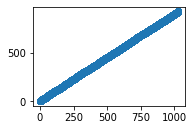

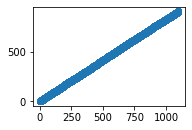

In [130]:
## do something with values to test how it looks like
print(testvicon)
visualise(testvicon)
print(vicontest)
visualise(vicontest)

In [132]:
## to be exported to the ML page

def prepareData(files):
    
    data = []
    for file in files:
        td = pd.read_csv(file, sep=',')
        data.append(td)
    data = pd.concat(data, ignore_index=True)
        
    data = data.drop(['loggingSample','identifierForVendor','locationTimestamp_since1970','locationSpeed','locationCourse','locationVerticalAccuracy','locationHorizontalAccuracy','locationFloor','locationHeadingTimestamp_since1970','accelerometerTimestamp_sinceReboot','gyroTimestamp_sinceReboot','magnetometerTimestamp_sinceReboot','motionTimestamp_sinceReboot','motionAttitudeReferenceFrame','motionMagneticFieldCalibrationAccuracy','pedometerStartDate','pedometerNumberofSteps','pedometerAverageActivePace','pedometerCurrentPace','pedometerCurrentCadence','pedometerDistance','pedometerFloorAscended','pedometerFloorDescended','pedometerEndDate','altimeterTimestamp_sinceReboot','altimeterReset','altimeterRelativeAltitude','altimeterPressure','deviceOrientation','locationHeadingX','locationHeadingY','locationHeadingZ','motionMagneticFieldX','motionMagneticFieldY','motionMagneticFieldZ'],axis=1)
    
    extra = (len(data)%100)
    data = data[:-extra]
    
    values = data[['accelerometerAccelerationX','accelerometerAccelerationY','accelerometerAccelerationZ','motionRotationRateZ','motionRotationRateX','motionRotationRateY','magnetometerX','magnetometerY','magnetometerZ']]
    target = data[['locationLatitude','locationLongitude']]
    values2 = data[['accelerometerAccelerationX','accelerometerAccelerationY','accelerometerAccelerationZ','motionRotationRateZ','motionRotationRateX','motionRotationRateY']]
    
    
    for i in range(len(target)):
        if (i+1) % 100 != 0:
            if i < len(target)-100:
                p = ((i+1) % 100)/100 
                b = (i // 100)*100
                blat, blong = target.loc[b, 'locationLatitude'], target.loc[b, 'locationLongitude']
                ulat, ulong = target.loc[b+100, 'locationLatitude'], target.loc[b+100, 'locationLongitude']
                target.loc[i, 'locationLatitude'] = target.loc[i, 'locationLatitude'] + p*(ulat - blat)
                target.loc[i, 'locationLongitude'] = target.loc[i, 'locationLongitude'] + p*(ulong - blong)
    
    res = []
    for i in range(len(target)):
        if (i+1) % 10 == 0:
            if i > 198:
                clat, clong = target.loc[i, 'locationLatitude'], target.loc[i, 'locationLongitude']
                plat, plong = target.loc[i-199, 'locationLatitude'], target.loc[i-199, 'locationLongitude']
                y = geopy.distance.distance((plat, 0),(clat,0)).km*1000
                x = geopy.distance.distance((0, plong),(0,clong)).km*1000
                res.append([x,y])
                
                
    target = pd.DataFrame(res)
    values = pd.DataFrame(values)
    values2 = pd.DataFrame(values2)
    
    sc = MinMaxScaler(feature_range = (0,1))
    values = sc.fit_transform(values)
    target = sc.fit_transform(target)
    values2 = sc.fit_transform(values2)
    values = view_as_windows(values,(200, 9),10)[:,0]
    
    return values, target, values2


values, target, values2 = prepareData(['IMU/coney2.csv','IMU/coney1.csv','IMU/coney3.csv'])
print(values.shape, target.shape)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(15101, 200, 9) (15101, 2)


/opt/anaconda3/lib/python3.7/site-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


In [80]:
model2 = keras.Sequential()

model2.add(layers.Bidirectional(layers.LSTM(96, input_shape=(None, 9))))

model2.add(layers.Dense(2))

adam = keras.optimizers.Adam(lr=0.0015)

model2.compile(optimizer=adam,loss='mean_squared_error')

model2.fit(values,target, epochs=90)

model2.summary()

Epoch 1/90
472/472 [==============================] - 42s 88ms/step - loss: 0.0099
Epoch 2/90
472/472 [==============================] - 43s 91ms/step - loss: 0.0085
Epoch 3/90
472/472 [==============================] - 44s 94ms/step - loss: 0.0084
Epoch 4/90
472/472 [==============================] - 44s 93ms/step - loss: 0.0082
Epoch 5/90
472/472 [==============================] - 44s 93ms/step - loss: 0.0082
Epoch 6/90
472/472 [==============================] - 45s 94ms/step - loss: 0.0082
Epoch 7/90
472/472 [==============================] - 45s 95ms/step - loss: 0.0081
Epoch 8/90
472/472 [==============================] - 43s 91ms/step - loss: 0.0081
Epoch 9/90
472/472 [==============================] - 43s 92ms/step - loss: 0.0080
Epoch 10/90
472/472 [==============================] - 43s 91ms/step - loss: 0.0079
Epoch 11/90
472/472 [==============================] - 44s 94ms/step - loss: 0.0079
Epoch 12/90
472/472 [==============================] - 43s 91ms/step - loss: 0.0080
E

In [135]:
## do something to visualise
testvalues, testtarget, testvalues2 = prepareData(['IMU/coney4.csv'])
testvalues2 = view_as_windows(testvalues2,(200, 6),10)[:,0]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/skimage/util

In [136]:
predtarget = model2.predict(testvalues)
predtarget2 = model.predict(testvalues2)

In [137]:
print(predtarget)
print(testtarget)
print(predtarget2)

[[0.3785954  0.08164126]
 [0.3766335  0.08773043]
 [0.3679583  0.08081998]
 ...
 [0.15012646 0.07450457]
 [0.14997138 0.06880127]
 [0.14401466 0.05970327]]
[[0.01178614 0.01840052]
 [0.00961414 0.02438778]
 [0.0074402  0.03037894]
 ...
 [0.05772084 0.0796633 ]
 [0.06174824 0.08519908]
 [0.02494734 0.03454477]]
[[0.23669608 0.5071715 ]
 [0.3332852  0.49775648]
 [0.24417709 0.49370483]
 ...
 [0.38572308 0.48668426]
 [0.20223513 0.49239227]
 [0.21125878 0.4994683 ]]


109.75742438286534
37.743926809355685
52.02021063307555
53.52593578746086
230.0945944339041
229.1374100267895


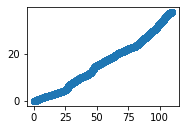

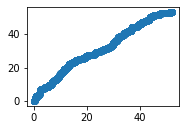

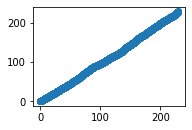

In [138]:
visualise(predtarget)
visualise(testtarget)
visualise(predtarget2)

### THE END